In [1]:
# For importing utils
import sys
sys.path.append("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from utils import PERTURBATIONS

/home/s2678328/miniconda3/envs/impossible/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/s2678328/miniconda3/envs/impossible/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/s2678328/miniconda3/envs/impossible/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [51]:
def plot_geometric_mean_perplexities(ax_i, ax, file_info, title, checkpoints, seeds, pos_encodings, warmup):
    
    nps = "" if pos_encodings else "_no_positional_encodings"
    wp = "_warmup" if warmup else ""

    results_path = 'perplexity_results{}/{}_100M{}/randinit_seed{}_test_{}.csv'

    for file_data in file_info:
        model_perturb, test_perturb, marker, linestyle, legend_name = file_data

        all_seeds_gmeans = []
        for seed in seeds:
            df = pd.read_csv(results_path.format(wp, model_perturb, nps, seed, test_perturb))
            gmeans = []

            # Calculate geometric means for each checkpoint
            for ckpt in checkpoints:
                gmeans.append(stats.gmean(df[f"Perplexities (ckpt {ckpt})"]))

            all_seeds_gmeans.append(gmeans)

        all_seeds_gmeans = np.array(all_seeds_gmeans)
        means = np.mean(all_seeds_gmeans, axis=0)

        

        print (f"{model_perturb}  {[f'{mean:.3f}' for mean in means]}")

        ci = None
        if len(seeds) > 1:
            sems = stats.sem(all_seeds_gmeans, axis=0)
            # Calculate confidence interval using t-distribution
            ci_lower, ci_upper = stats.t.interval(0.95, df=len(seeds)-1,
                                                loc=means, scale=sems)
            ci = (ci_upper - ci_lower) / 2

        # Plotting
        ax.errorbar(checkpoints, means, ci, marker=marker, 
                    color=PERTURBATIONS[test_perturb]["color"],
                    linestyle=linestyle, label=legend_name)

    ax.set_title(title)
    if ax_i == 0:
        ax.set_ylabel("Geometric Mean Perplexity", fontsize=12)
    
    if not pos_encodings and title == "*Shuffle":
        ax.legend(fontsize=6)
    elif title == "*Shuffle":
        ax.legend(fontsize=8, framealpha=1)
    else:
        ax.legend(fontsize=9, framealpha=1)
    ax.grid(True, color="lightgray")
    ax.set_ylim(top=1000)

In [52]:
def plot_perplexities_grouped(file_infos, titles, checkpoints, seeds, pos_encodings=True, warmup=False):
    
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(1, len(file_infos), figsize=(16, 5), sharey=False, sharex=True)
    fig.subplots_adjust(wspace=0.15)
    fig.supxlabel("Training Steps", fontsize=12)
    
    axs_flat = axs.flatten()
    
    # Call individual plot function with different parameters for each subplot
    for i, (file_info, title) in enumerate(zip(file_infos, titles)):
        plot_geometric_mean_perplexities(
            i, axs_flat[i], file_info, title, checkpoints, seeds, pos_encodings, warmup)

In [53]:
MAX_TRAINING_STEPS = 3000
CHECKPOINTS = list(range(200, MAX_TRAINING_STEPS+1, 200))
SEEDS = [41] #[0, 14, 41, 53, 96]


shuffle_file_info = [
    ("shuffle_control", "shuffle_control", 'o', "-", 'NoShuffle'),
    ("shuffle_nondeterministic", "shuffle_nondeterministic", "s", "-", 'NondeterministicShuffle'),
    ("shuffle_deterministic21", "shuffle_deterministic21", "v", "-", 'DeterministicShuffle$(s=21)$'),
    ("lemma_shuffle_control","lemma_shuffle_control", "v",":","LemmaNoShuffle"),
    ("lemma_shuffle_nondeterministic","lemma_shuffle_nondeterministic","d","--","LemmaNondetrministicShuffle"),
    ("lemma_shuffle_deterministic21","lemma_shuffle_deterministic21","^","--","LemmaDetrerminisiticShuffle$(s=21)$")
    # ("shuffle_deterministic57", "shuffle_deterministic57", "v", ":", 'DeterministicShuffle$(s=57)$'),
    # ("shuffle_deterministic84", "shuffle_deterministic84", "v", "--", 'DeterministicShuffle$(s=84)$'),
    # ("shuffle_local3", "shuffle_local3", "^", "-", 'LocalShuffle$(w=3)$'),
    # ("shuffle_local5", "shuffle_local5", "^", ":", 'LocalShuffle$(w=5)$'),
    # ("shuffle_local10", "shuffle_local10", "^", "--", 'LocalShuffle$(w=10)$'),
    # ("shuffle_even_odd", "shuffle_even_odd", "d", "-", 'EvenOddShuffle'),
]
reverse_file_info = [
    ("reverse_control", "reverse_control", 'o', "-", 'NoReverse'),
    ("reverse_partial", "reverse_partial", "s", "-", 'PartialReverse'),
    ("reverse_full", "reverse_full", 'v', "-", 'FullReverse'),
]
hop_file_info = [
    ("hop_control", "hop_control", 'o', "-", 'NoHop'),
    ("hop_tokens4", "hop_tokens4", "s", "-", 'TokenHop'),
    ("hop_words4", "hop_words4", 'v', "-", 'WordHop'),
]

# Plot
# plot_perplexities_grouped([shuffle_file_info], # reverse_file_info, hop_file_info], 
#                           ["*Shuffle"], # "*Reverse", "*Hop"],
#                           CHECKPOINTS, SEEDS)
# plt.savefig("figures/perplexities.pdf", format="pdf", bbox_inches="tight")

# # No Pos Encodings
# plot_perplexities_grouped([shuffle_file_info, reverse_file_info, hop_file_info], 
#                           ["*Shuffle", "*Reverse", "*Hop"],
#                           CHECKPOINTS, [53], pos_encodings=False)
# plt.savefig("figures/perplexities_no_pos_encodings.pdf", format="pdf", bbox_inches="tight")

In [54]:
def plot_perplexities_grouped(file_infos, titles, checkpoints, seeds, pos_encodings=True, warmup=False):
    # Create subplots
    fig, axs = plt.subplots(1, len(file_infos), figsize=(16, 5), sharey=False, sharex=True)
    fig.subplots_adjust(wspace=0.15)
    fig.supxlabel("Training Steps", fontsize=12)

    # Normalize axs to always be iterable
    if isinstance(axs, np.ndarray):
        axs_flat = axs.flatten()
    else:
        axs_flat = [axs]

    # Plot each subplot
    for i, (file_info, title) in enumerate(zip(file_infos, titles)):
        # print (axs_flat[i])
        plot_geometric_mean_perplexities(
            i, axs_flat[i], file_info, title, checkpoints, seeds, pos_encodings, warmup)

In [ ]:
def plot_and_save(file_infos, titles, checkpoints, seeds, filename, pos_encodings=True, warmup=False):
    plot_perplexities_grouped(file_infos, titles, checkpoints, seeds, pos_encodings, warmup)
    
    plt.savefig(filename, format="pdf", bbox_inches="tight")
    plt.show()
    plt.close()

model [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000]
shuffle_control  ['889.963', '359.587', '229.715', '157.754', '129.135', '113.875', '110.648', '105.874', '100.264', '102.092', '99.720', '88.270', '93.866', '86.137', '83.691', '83.714', '84.194', '83.426', '81.047', '82.175', '79.908', '78.735', '78.212', '77.499', '77.944', '76.748', '76.265', '76.095', '76.083', '76.026']
shuffle_nondeterministic  ['5693.536', '1637.227', '876.042', '702.190', '606.455', '643.384', '674.158', '673.745', '711.630', '633.781', '652.157', '649.368', '652.475', '646.637', '573.531', '563.730', '588.769', '569.057', '544.366', '532.665', '524.716', '517.184', '512.908', '524.181', '518.012', '499.558', '506.445', '503.580', '501.474', '500.105']
shuffle_deterministic21  ['1825.987', '1097.163', '838.389', '603.461', '615.837', '672.098', '665.321', '719.430', '668.949', '661.241

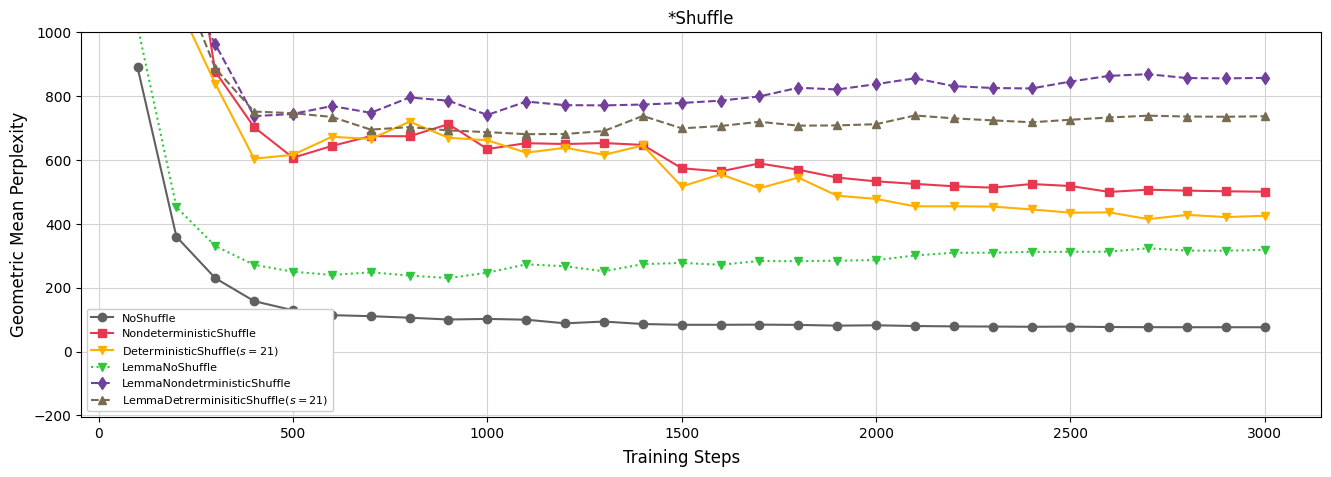

In [57]:
MAX_TRAINING_STEPS = 3000
CHECKPOINTS = list(range(100, MAX_TRAINING_STEPS + 1, 100))
SEEDS = [41]  # or more seeds

print ("model", CHECKPOINTS)
# Plot for positional encodings
plot_and_save(
    [shuffle_file_info],
    ["*Shuffle"],
    CHECKPOINTS,
    SEEDS,
    "figures/perplexities.pdf"
)

# Plot without positional encodings
# plot_and_save(
#     [shuffle_file_info, reverse_file_info, hop_file_info],
#     ["*Shuffle", "*Reverse", "*Hop"],
#     CHECKPOINTS,
#     # [53],
#     "figures/perplexities_no_pos_encodings.pdf",
#     pos_encodings=False
# )

shuffle_deterministic21  ['1825.9866', '1097.1629', '838.3890', '603.4606', '615.8372', '672.0979', '665.3207', '719.4298', '668.9494', '661.2405', '622.2239', '637.7821', '615.6723', '644.9747', '516.6859', '554.7140', '511.0254', '544.4775', '487.5346', '477.7520', '454.3997', '454.5953', '453.6310', '444.7412', '434.5923', '435.5376', '414.3628', '427.7095', '420.8399', '424.9012']


FileNotFoundError: [Errno 2] No such file or directory: 'perplexity_results/shuffle_deterministic21_100M/randinit_seed41_test_shuffle_deterministic57.csv'

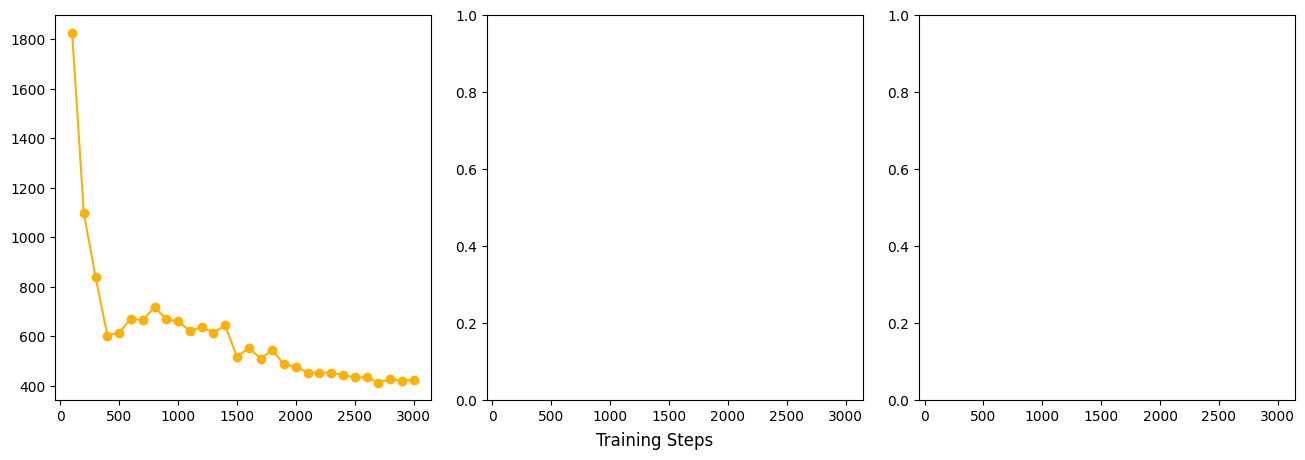

In [50]:
shuffle21_file_info = [
    ("shuffle_deterministic21", "shuffle_deterministic21", "o", "-", 'DeterministicShuffle$(s=21)$ Test Set'),
    ("shuffle_deterministic21", "shuffle_deterministic57", "v", ":", 'DeterministicShuffle$(s=57)$ Test Set'),
    ("shuffle_deterministic21", "shuffle_deterministic84", "^", "--", 'DeterministicShuffle$(s=84)$ Test Set'),
    ("shuffle_deterministic21", "shuffle_nondeterministic", "s", "-", 'NondeterministicShuffle Test Set'),
]
shuffle57_file_info = [
    ("shuffle_deterministic57", "shuffle_deterministic21", "o", "-", 'DeterministicShuffle$(s=21)$ Test Set'),
    ("shuffle_deterministic57", "shuffle_deterministic57", "v", ":", 'DeterministicShuffle$(s=57)$ Test Set'),
    ("shuffle_deterministic57", "shuffle_deterministic84", "^", "--", 'DeterministicShuffle$(s=84)$ Test Set'),
    ("shuffle_deterministic57", "shuffle_nondeterministic", "s", "-", 'NondeterministicShuffle Test Set'),
]
shuffle84_file_info = [
    ("shuffle_deterministic84", "shuffle_deterministic21", "o", "-", 'DeterministicShuffle$(s=21)$ Test Set'),
    ("shuffle_deterministic84", "shuffle_deterministic57", "v", ":", 'DeterministicShuffle$(s=57)$ Test Set'),
    ("shuffle_deterministic84", "shuffle_deterministic84", "^", "--", 'DeterministicShuffle$(s=84)$ Test Set'),
    ("shuffle_deterministic84", "shuffle_nondeterministic", "s", "-", 'NondeterministicShuffle Test Set'),
]

# Plot
plot_perplexities_grouped([shuffle21_file_info, shuffle57_file_info, shuffle84_file_info], 
                          ["DeterministicShuffle$(s=21)$ Model", "DeterministicShuffle$(s=57)$ Model",
                           "DeterministicShuffle$(s=84)$ Model"],
                          CHECKPOINTS, SEEDS)
plt.savefig("figures/perplexities_deterministic_shuffle.pdf", format="pdf", bbox_inches="tight")

# No Pos Encodings
plot_perplexities_grouped([shuffle21_file_info, shuffle57_file_info, shuffle84_file_info], 
                          ["DeterministicShuffle$(s=21)$ Model", "DeterministicShuffle$(s=57)$ Model",
                           "DeterministicShuffle$(s=84)$ Model"],
                          CHECKPOINTS, [53], pos_encodings=False)
plt.savefig("figures/perplexities_deterministic_shuffle_no_pos_encodings.pdf", format="pdf", bbox_inches="tight")

## Results with different warm-up hyperparameters

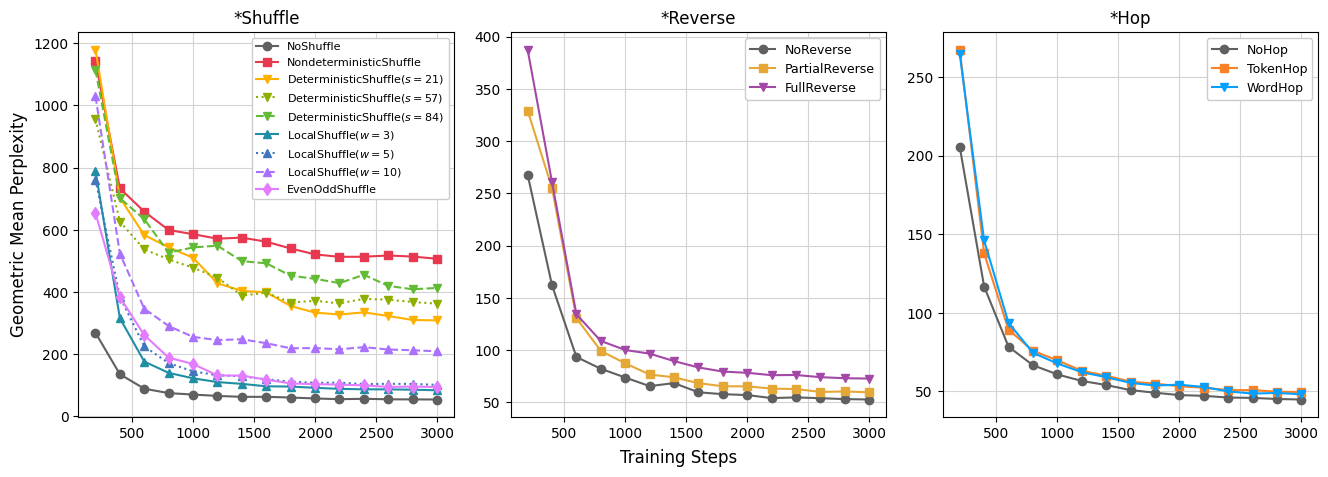

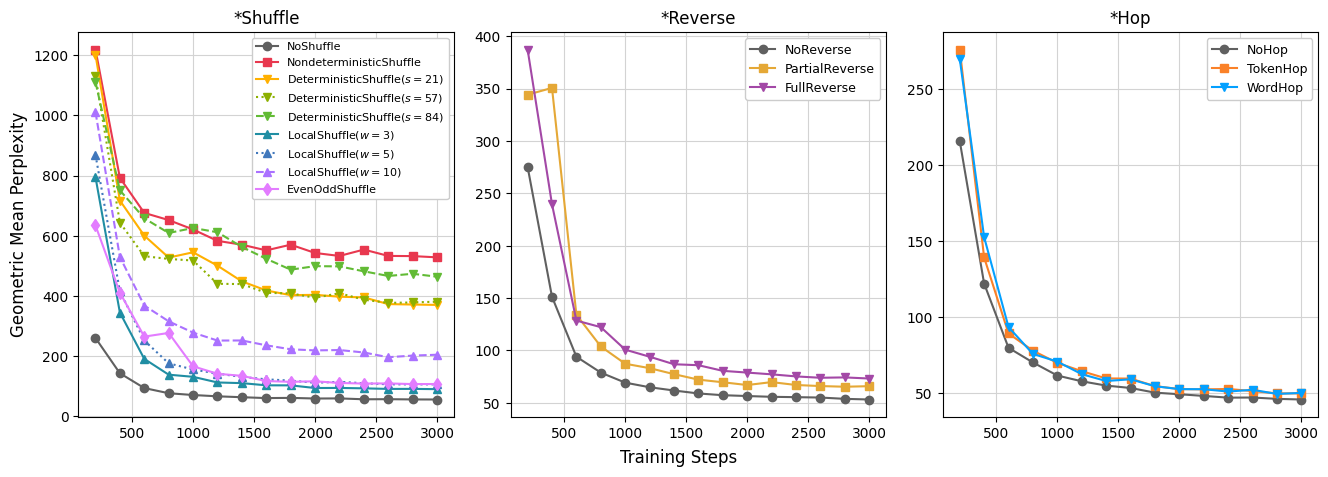

In [7]:
MAX_TRAINING_STEPS = 3000
CHECKPOINTS = list(range(200, MAX_TRAINING_STEPS+1, 200))


shuffle_file_info = [
    ("shuffle_control", "shuffle_control", 'o', "-", 'NoShuffle'),
    ("shuffle_nondeterministic", "shuffle_nondeterministic", "s", "-", 'NondeterministicShuffle'),
    ("shuffle_deterministic21", "shuffle_deterministic21", "v", "-", 'DeterministicShuffle$(s=21)$'),
    ("shuffle_deterministic57", "shuffle_deterministic57", "v", ":", 'DeterministicShuffle$(s=57)$'),
    ("shuffle_deterministic84", "shuffle_deterministic84", "v", "--", 'DeterministicShuffle$(s=84)$'),
    ("shuffle_local3", "shuffle_local3", "^", "-", 'LocalShuffle$(w=3)$'),
    ("shuffle_local5", "shuffle_local5", "^", ":", 'LocalShuffle$(w=5)$'),
    ("shuffle_local10", "shuffle_local10", "^", "--", 'LocalShuffle$(w=10)$'),
    ("shuffle_even_odd", "shuffle_even_odd", "d", "-", 'EvenOddShuffle'),
]
reverse_file_info = [
    ("reverse_control", "reverse_control", 'o', "-", 'NoReverse'),
    ("reverse_partial", "reverse_partial", "s", "-", 'PartialReverse'),
    ("reverse_full", "reverse_full", 'v', "-", 'FullReverse'),
]
hop_file_info = [
    ("hop_control", "hop_control", 'o', "-", 'NoHop'),
    ("hop_tokens4", "hop_tokens4", "s", "-", 'TokenHop'),
    ("hop_words4", "hop_words4", 'v', "-", 'WordHop'),
]

# Plot
plot_perplexities_grouped([shuffle_file_info, reverse_file_info, hop_file_info], 
                          ["*Shuffle", "*Reverse", "*Hop"],
                          CHECKPOINTS, [96])
plt.savefig("figures/perplexities_warmup1000.pdf", format="pdf", bbox_inches="tight")

plot_perplexities_grouped([shuffle_file_info, reverse_file_info, hop_file_info], 
                          ["*Shuffle", "*Reverse", "*Hop"],
                          CHECKPOINTS, [0])
plt.savefig("figures/perplexities_warmup4000.pdf", format="pdf", bbox_inches="tight")